In [1]:
! pip install tensorflow
! pip install opencv-python


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/ea/df/55525e489c43f9dbb6c8ea27d8a567b3dcd18a22f3c45483055f5ca6611d/libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/p

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import PIL
import cv2
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import boto3
import sagemaker

In [3]:
s3 = boto3.client('s3')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'covid19xraydatasets'
print("Using bucket " + bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using bucket covid19xraydatasets


In [8]:
data_path = 's3://covid19xraydatasets/dataset/'

In [20]:
s3_bucket_name = 'covid19xraydatasets'
s3_prefix = 'dataset/'

# List objects in the specified S3 prefix
response = s3.list_objects_v2(Bucket='covid19xraydatasets', Prefix='dataset/', Delimiter='/')

# Extract directory names and assign labels
categories = []
labels = {}
label_counter = 0

for obj in response.get('CommonPrefixes', []):
    category = obj['Prefix'].replace(s3_prefix, '')
    categories.append(category)
    labels[category] = label_counter
    label_counter += 1

# Print directory names and their corresponding labels
for category in categories:
    print(category)

print(labels)

negative/
positive/
{'negative/': 0, 'positive/': 1}


In [21]:
for category in categories:
        print(category)

negative/
positive/


In [24]:
img_size = 100
data = []
target = []

for category in categories:
        print(category)
        folder_path = f's3://covid19xraydatasets/{data_path}/{category}/'
        prefix_data = f'dataset/{category}'
        response = s3.list_objects(Bucket='covid19xraydatasets', Prefix=prefix_data)
        for obj in response.get('Contents', []):
            img_name = obj['Key'].split('/')[-1]
            img_path = f"s3://covid19xraydatasets/{obj['Key']}"
            try:
                image_data = s3.get_object(Bucket='covid19xraydatasets', Key=obj['Key'])['Body'].read()
                img = cv2.imdecode(np.asarray(bytearray(image_data), dtype="uint8"), cv2.IMREAD_COLOR)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(gray, (img_size, img_size))
                data.append(resized)
                target.append(labels[category])
            except Exception as e:
                print('Exception:', e)

negative/
positive/


In [25]:

# Normalize your data by dividing by 255.0
data = np.array(data) / 255.0

# Reshape your data
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))

# Convert your target labels to categorical format using tf.keras.utils
from tensorflow.keras.utils import to_categorical

new_target = to_categorical(target)

In [26]:
np.save('data',data)
np.save('target',new_target)

In [27]:
data=np.load('data.npy')
target=np.load('target.npy')

In [28]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parallel_kernels=[3,5,7]

for k in range(len(parallel_kernels)):

    conv = Conv2D(128, parallel_kernels[k], padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

2023-10-29 16:45:26.715888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:45:40.323527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:45:40.323761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 100, 100, 384)     11008     
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        221248    
                                                                 
 activation (Activation)     (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 47, 47, 32)        0         
                                                        

s-bus-pci#L344-L355
2023-10-29 16:45:40.325444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:45:40.325602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:45:41.926278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

In [29]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [30]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/20


2023-10-29 16:47:08.633455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-29 16:48:18.007705: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55acb5d374f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 16:48:18.007735: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-10-29 16:48:18.013551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 16:48:18.213237: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.7202INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


40/40 [==============================] - 175s 201ms/step - loss: 0.4941 - accuracy: 0.7202 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9257INFO:tensorflow:Assets written to: model-002.model/assets


INFO:tensorflow:Assets written to: model-002.model/assets


40/40 [==============================] - 5s 124ms/step - loss: 0.2208 - accuracy: 0.9257 - val_loss: 0.1151 - val_accuracy: 0.9504
Epoch 3/20
40/40 [==============================] - 4s 95ms/step - loss: 0.1389 - accuracy: 0.9431 - val_loss: 0.1168 - val_accuracy: 0.9433
Epoch 4/20
40/40 [==============================] - 4s 95ms/step - loss: 0.1189 - accuracy: 0.9621 - val_loss: 0.1773 - val_accuracy: 0.9291
Epoch 5/20
40/40 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9668INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: model-005.model/assets


40/40 [==============================] - 5s 131ms/step - loss: 0.1158 - accuracy: 0.9668 - val_loss: 0.0858 - val_accuracy: 0.9433
Epoch 6/20
40/40 [==============================] - 4s 95ms/step - loss: 0.1004 - accuracy: 0.9644 - val_loss: 0.1096 - val_accuracy: 0.9504
Epoch 7/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0881 - accuracy: 0.9708 - val_loss: 0.0904 - val_accuracy: 0.9574
Epoch 8/20
40/40 [==============================] - 4s 95ms/step - loss: 0.1019 - accuracy: 0.9684 - val_loss: 0.1280 - val_accuracy: 0.9433
Epoch 9/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0928 - accuracy: 0.9676 - val_loss: 0.1137 - val_accuracy: 0.9433
Epoch 10/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0603 - accuracy: 0.9747 - val_loss: 0.1111 - val_accuracy: 0.9574
Epoch 11/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0708 - accuracy: 0.9763 - val_loss: 0.1047 - val_accuracy: 0.9574
Epoch 12/20
40/40 [==

INFO:tensorflow:Assets written to: model-012.model/assets


40/40 [==============================] - 5s 124ms/step - loss: 0.0456 - accuracy: 0.9866 - val_loss: 0.0781 - val_accuracy: 0.9645
Epoch 13/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0313 - accuracy: 0.9874 - val_loss: 0.0826 - val_accuracy: 0.9504
Epoch 14/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.0827 - val_accuracy: 0.9716
Epoch 15/20
40/40 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9874INFO:tensorflow:Assets written to: model-015.model/assets


INFO:tensorflow:Assets written to: model-015.model/assets


40/40 [==============================] - 5s 124ms/step - loss: 0.0328 - accuracy: 0.9874 - val_loss: 0.0664 - val_accuracy: 0.9716
Epoch 16/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0303 - accuracy: 0.9889 - val_loss: 0.0963 - val_accuracy: 0.9645
Epoch 17/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0316 - accuracy: 0.9874 - val_loss: 0.0726 - val_accuracy: 0.9716
Epoch 18/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 0.0825 - val_accuracy: 0.9645
Epoch 19/20
40/40 [==============================] - 4s 96ms/step - loss: 0.0221 - accuracy: 0.9913 - val_loss: 0.0795 - val_accuracy: 0.9716
Epoch 20/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0229 - accuracy: 0.9921 - val_loss: 0.1415 - val_accuracy: 0.9645


In [53]:
model.save('Covid-19_X-ray_diagnosis.h5')

In [17]:
from keras.models import load_model
model = load_model('Covid-19_X-ray_diagnosis.h5')

In [32]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 1s 294ms/step - loss: 0.0694 - accuracy: 0.9936
[0.06940749287605286, 0.993630588054657]


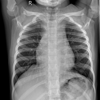

In [44]:
from PIL import Image
from io import BytesIO

s3_bucket = 'covid19xraydatasets'
s3_object_key = 'dataset/negative/IM-0695-0001.jpeg'

# Download the image from S3
s3_response = s3.get_object(Bucket=s3_bucket, Key=s3_object_key)
image_data = s3_response['Body'].read()

# Load the image using Pillow
img = Image.open(BytesIO(image_data))
img = img.resize((100, 100))
img

In [50]:
def preprocess(img):
    img=np.array(img)
    if(img.ndim==3):
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray=img
    gray=gray/255
    resized=cv2.resize(gray,(img_size,img_size))
    reshaped=resized.reshape(1,img_size,img_size)
    return reshaped

In [48]:
def predict(img):
    img=preprocess(img)
    prediction = model.predict(img)
    result=np.argmax(prediction)
    if(result == 0):
        print("Negative")
    else:
        print("Positive")
predict(img)

1/1 [==============================] - 0s 17ms/step
Negative
